In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata

In [2]:
train = pd.read_csv('/kaggle/input/spam-data/train_spam.csv')
test = pd.read_csv('/kaggle/input/spam-data/test_spam.csv')

## EDA

In [3]:
train['text_type'].value_counts()/train.shape[0]

text_type
ham     0.704571
spam    0.295429
Name: count, dtype: float64

Дисбаланс есть но он не супер сильный

In [18]:
train['text_len'] = train['text'].str.len()
test['text_len'] = test['text'].str.len()

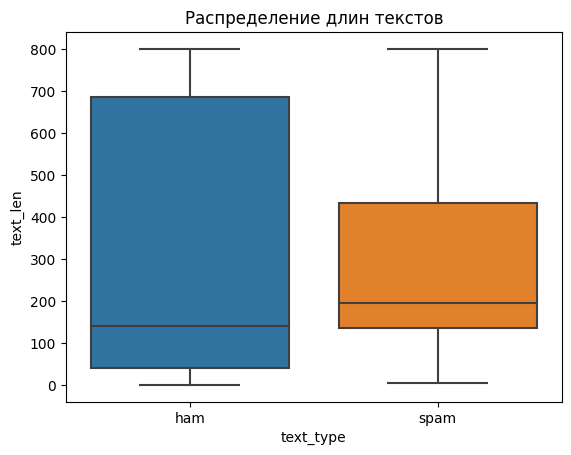

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(train,x = 'text_type', y = 'text_len')
plt.title('Распределение длин текстов');

У спама не такой большой разброс как у обычных текстов и медиана завышена 

прежде чем делать препроцессинг нужно определиться с тем имеют ли для нас значения цифры и знаки пунктуации

In [19]:
for dataset in [train,test]:
    dataset['contains_digit_symbols'] = dataset['text'].map(lambda x: any(ch.isdigit() for ch in x))
    dataset['contains_digit'] = dataset['text'].map(lambda x: any(word.isdigit() for word in x.split()))
    dataset['cnt_digits'] = None
    dataset['avg_len_digits'] = None
    dataset.loc[dataset['contains_digit'],['cnt_digits']] = dataset[dataset['contains_digit']]['text'].map(lambda x: sum(word.isdigit() for word in x.split()))
    dataset.loc[dataset['contains_digit'],['avg_len_digits']] = dataset[dataset['contains_digit']]['text'].map(lambda x: np.mean([len(word) for word in x.split() if word.isdigit()]))

In [20]:
train.groupby('text_type').agg({'contains_digit':'mean','contains_digit_symbols':'mean','cnt_digits':'mean','avg_len_digits':'mean'})

,contains_digit,contains_digit_symbols,cnt_digits,avg_len_digits
text_type,,,,
ham,0.456535,0.488622,7.7034,3.601138
spam,0.628197,0.769807,4.206223,3.789545


Видно что в спаме гораздо чаще встречаются цифры, причем их количество в среднем гораздо меньше чем в ham текстах, однако по средней длине цифр в тексте spam и ham почти не отличаются

In [10]:
print('spam:',train[train['contains_digit_symbols'] & (~train['contains_digit']) & (train['text_type'] == 'spam')]['text'].map(lambda x: [word for word in x.split() if any(ch.isdigit() for ch in word)]))
print('ham:',train[train['contains_digit_symbols'] & (~train['contains_digit']) & (train['text_type'] == 'ham')]['text'].map(lambda x: [word for word in x.split() if any(ch.isdigit() for ch in word)]))

spam: 21        [covid19?the, covid19, covid19, covid19]
86                    [picsfree1, 2day, picsfree1]
123                        [$10000, $50000, $5000]
129                           [$500, 3days, $5500]
133      [$500, $5000, $800, $8000, $1000, $10000]
                           ...                    
16186                       [£200, £2500, 28hours]
16204         [$15000, $1500, $300, $3500, 24𝒉𝒖𝒓𝒔]
16261                                [$5000$50000]
16272                              [₹50, pik74cad]
16273                              [+447441465743]
Name: text, Length: 681, dtype: object
ham: 33                                              [iblong2u]
210                                                 [app2]
250      [hosting1635465, pop1635465, pop1635465, pop16...
330                                           [paran0rmal]
492                                                  [1pm]
                               ...                        
16087                              

Как будем обрабатывать цифры: отделять их от других символов пробелами, и заменять их единым специальным токеном, а статистики выше добавлять к tf-idf вектору например просто отдельными признаками

Посмотрим какие еще типы символов бывают (кроме знаков препинания цифр и слов)

In [21]:
def remove_punkt(word):
    punct = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punct:
        word = word.replace(p,'')
    return word

train['strange_words'] = train['text'].map(lambda x: [word for word in x.split() if not remove_punkt(word).isalnum()])
strange = train[train['strange_words'].str.len() != 0]
print(strange['text_type'].value_counts()/len(strange))
display(strange)

text_type
spam    0.786772
ham     0.213228
Name: count, dtype: float64


,text_type,text,text_len,contains_digit_symbols,contains_digit,cnt_digits,avg_len_digits,strange_words,processed_text,text_without_specials
2,spam,plzz visit my website moviesgodml to get all m...,126,False,False,None,None,[ads😊😊😊😊😁],plzz visit my website moviesgodml to get all m...,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...,139,True,True,2,7.5,[£2000],urgent your mobile number have be award with a...,urgent your mobile number has been awarded wit...
35,spam,after i lost my job i taught life has come to ...,563,False,False,None,None,[below👇👇👇👇👇👇👇👇👇],after I lose my job I teach life have come to ...,after i lost my job i taught life has come to ...
38,spam,𝑰𝒕𝒔 𝒕𝒉𝒆 𝒔𝒆𝒄𝒐𝒏𝒅 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒓𝒆𝒄𝒆𝒊𝒗𝒊𝒏𝒈 𝒎𝒚 𝒑𝒓𝒐𝒇𝒊𝒕 𝒇𝒓𝒐...,172,True,True,1,5.0,"[👇👇👇, 📱📱📱📱]",𝑰𝒕𝒔 𝒕𝒉𝒆 𝒔𝒆𝒄𝒐𝒏𝒅 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒓𝒆𝒄𝒆𝒊𝒗𝒊𝒏𝒈 𝒎𝒚 𝒑𝒓𝒐𝒇𝒊𝒕 𝒇𝒓𝒐...,𝑰𝒕𝒔 𝒕𝒉𝒆 𝒔𝒆𝒄𝒐𝒏𝒅 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒓𝒆𝒄𝒆𝒊𝒗𝒊𝒏𝒈 𝒎𝒚 𝒑𝒓𝒐𝒇𝒊𝒕 𝒇𝒓𝒐...
52,spam,✉️ internshala studentinternshala com akshay p...,336,True,True,1,2.0,"[✉️, 🌟]",catSo catMn internshala studentinternshala com...,✉️ internshala studentinternshala com akshay p...
...,...,...,...,...,...,...,...,...,...,...
16264,spam,i just created my youtube channel 3 days ago t...,282,True,True,2,1.5,[?],I just create my youtube channel catDigit day ...,i just created my youtube channel 3 days ago t...
16270,ham,greeting from charles happy new year to you as...,743,True,True,9,2.888889,"[, ]",greet from charles happy new year to you as we...,greeting from charles happy new year to you as...
16271,spam,rs 250 for dental services worth rs 2150 denta...,130,True,True,5,3.2,[/],rs catDigit for dental service worth rs catDig...,rs 250 for dental services worth rs 2150 denta...
16272,spam,dost i am playing cricket knifeup pool etc and...,196,True,False,None,None,[₹50],dost I be play cricket knifeup pool etc and wi...,dost i am playing cricket knifeup pool etc and...


Как мы видим наличие таких странных символов гораздо больше характерно для спама, и если их удалить мы можем потерять важный сигнал поэтому их тоже будем заменять на единый токен. Но предварительно мы разделим их на группы - потому что смайлы и символы валюты - это разное


In [23]:
def get_category(char):
    if len(char) > 1:
        return ''
    category = unicodedata.category(char)
    if category =='So':
         if 0x1F600 <= ord(char) <= 0x1F64F or 0x1F300 <= ord(char) <= 0x1F5FF:
            category = 'Ss'
    if category in ['Ll','Lu','Nd']:
         return ''
    return 'cat' + category

strange['category'] = strange['strange_words'].map(lambda x: [get_category(ch) for word in x for ch in word])
strange       

/tmp/ipykernel_34/3702445544.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strange['category'] = strange['strange_words'].map(lambda x: [get_category(ch) for word in x for ch in word])


,text_type,text,text_len,contains_digit_symbols,contains_digit,cnt_digits,avg_len_digits,strange_words,processed_text,text_without_specials,category
2,spam,plzz visit my website moviesgodml to get all m...,126,False,False,None,None,[ads😊😊😊😊😁],plzz visit my website moviesgodml to get all m...,plzz visit my website moviesgodml to get all m...,"[, , , catSs, catSs, catSs, catSs, catSs]"
3,spam,urgent your mobile number has been awarded wit...,139,True,True,2,7.5,[£2000],urgent your mobile number have be award with a...,urgent your mobile number has been awarded wit...,"[catSc, , , , ]"
35,spam,after i lost my job i taught life has come to ...,563,False,False,None,None,[below👇👇👇👇👇👇👇👇👇],after I lose my job I teach life have come to ...,after i lost my job i taught life has come to ...,"[, , , , , catSs, catSs, catSs, catSs, catSs, ..."
38,spam,𝑰𝒕𝒔 𝒕𝒉𝒆 𝒔𝒆𝒄𝒐𝒏𝒅 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒓𝒆𝒄𝒆𝒊𝒗𝒊𝒏𝒈 𝒎𝒚 𝒑𝒓𝒐𝒇𝒊𝒕 𝒇𝒓𝒐...,172,True,True,1,5.0,"[👇👇👇, 📱📱📱📱]",𝑰𝒕𝒔 𝒕𝒉𝒆 𝒔𝒆𝒄𝒐𝒏𝒅 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒓𝒆𝒄𝒆𝒊𝒗𝒊𝒏𝒈 𝒎𝒚 𝒑𝒓𝒐𝒇𝒊𝒕 𝒇𝒓𝒐...,𝑰𝒕𝒔 𝒕𝒉𝒆 𝒔𝒆𝒄𝒐𝒏𝒅 𝒕𝒊𝒎𝒆 𝒐𝒇 𝒓𝒆𝒄𝒆𝒊𝒗𝒊𝒏𝒈 𝒎𝒚 𝒑𝒓𝒐𝒇𝒊𝒕 𝒇𝒓𝒐...,"[catSs, catSs, catSs, catSs, catSs, catSs, catSs]"
52,spam,✉️ internshala studentinternshala com akshay p...,336,True,True,1,2.0,"[✉️, 🌟]",catSo catMn internshala studentinternshala com...,✉️ internshala studentinternshala com akshay p...,"[catSo, catMn, catSs]"
...,...,...,...,...,...,...,...,...,...,...,...
16264,spam,i just created my youtube channel 3 days ago t...,282,True,True,2,1.5,[?],I just create my youtube channel catDigit day ...,i just created my youtube channel 3 days ago t...,[catPo]
16270,ham,greeting from charles happy new year to you as...,743,True,True,9,2.888889,"[, ]",greet from charles happy new year to you as we...,greeting from charles happy new year to you as...,"[catCc, catCc]"
16271,spam,rs 250 for dental services worth rs 2150 denta...,130,True,True,5,3.2,[/],rs catDigit for dental service worth rs catDig...,rs 250 for dental services worth rs 2150 denta...,[catPo]
16272,spam,dost i am playing cricket knifeup pool etc and...,196,True,False,None,None,[₹50],dost I be play cricket knifeup pool etc and wi...,dost i am playing cricket knifeup pool etc and...,"[catSc, , ]"


Соответственно все символы которые не являются буквами и цифрами мы будем заменять на токен их категории в юникоде

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
def preprocess(text):
    text = text.lower()
    pattern = r'(\d+|[^\w\s])'
    text = re.sub(pattern, r' \1 ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+','catDigit',text)
    text = [get_category(str(word)) if len(get_category(str(word))) > 0
                               else word.lemma_
                               for word in nlp(text)]
    return ' '.join(text)

In [26]:
preprocess('following👇👇👇 here you _??? +456 dogs2cat')

'follow catSs catSs catSs here you catPc catPo catPo catPo catSm catDigit dog catDigit cat'

In [16]:
train['processed_text'] = train['text'].map(lambda x: preprocess(x))

In [28]:
test['processed_text'] = test['text'].map(lambda x: preprocess(x))

Посмотрим на облака слов для спама и для обычных текстов

SPAM:


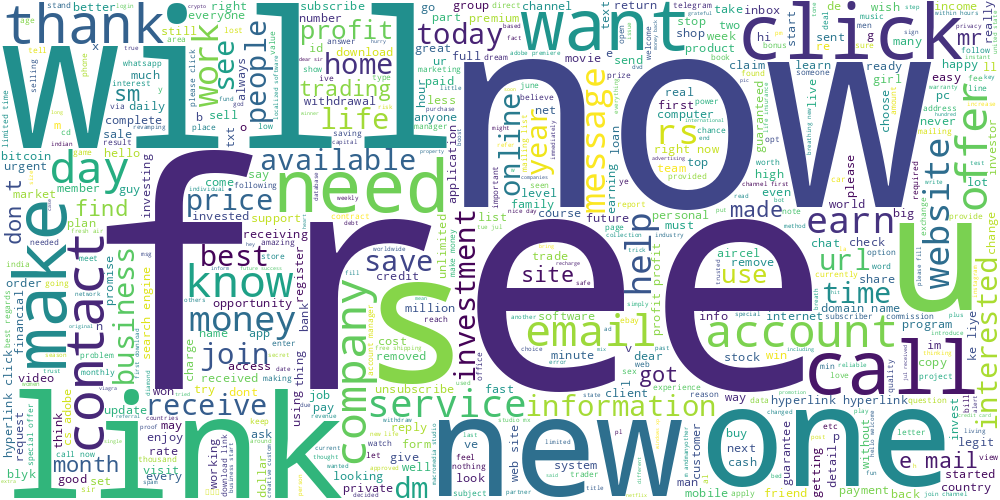

HAM:


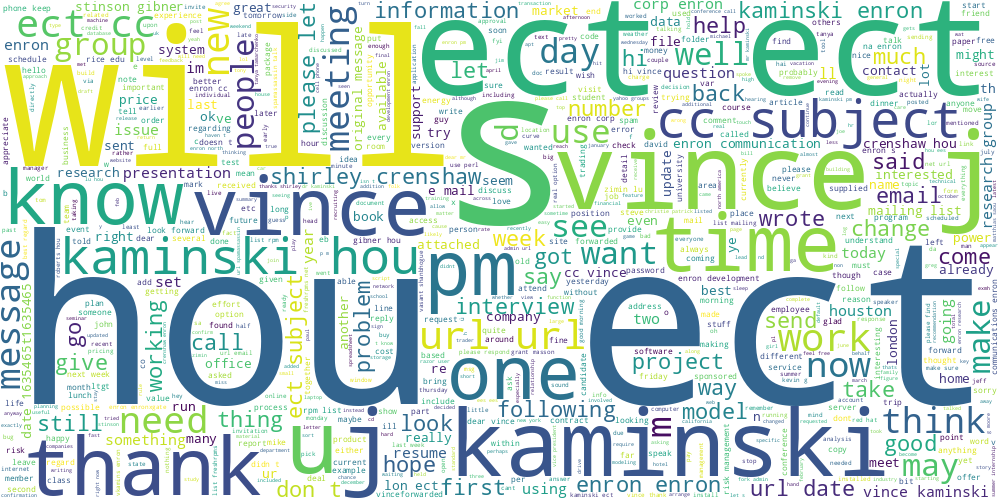

In [29]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)

    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

train['text_without_specials'] = train.text.map(lambda text: ' '.join(filter(lambda word: word.lower() == word,text.split())))
print('SPAM:')
display(draw_wordcloud(train[train['text_type'] == 'spam'].text_without_specials))
print('HAM:')
display(draw_wordcloud(train[train['text_type'] == 'ham'].text_without_specials))

Как мы видим облака слов достаточно сильно отличаются, в спаме обычно предлагают перейти по ссылке, заманивают кликбейтными словами и так далее

Разделим train данные на обучающую и валидационную выборку

In [30]:
train

,text_type,text,text_len,contains_digit_symbols,contains_digit,cnt_digits,avg_len_digits,strange_words,processed_text,text_without_specials
0,ham,make sure alex knows his birthday is over in f...,86,False,False,None,None,[],make sure alex know his birthday be over in fi...,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...,520,True,True,5,2.4,[],a resume for john lavorato thanks vince I will...,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...,126,False,False,None,None,[ads😊😊😊😊😁],plzz visit my website moviesgodml to get all m...,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...,139,True,True,2,7.5,[£2000],urgent your mobile number have be award with a...,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...,733,True,True,5,2.4,[],overview of hr associates analyst project per ...,overview of hr associates analyst project per ...
...,...,...,...,...,...,...,...,...,...,...
16273,spam,if you are interested in binary options tradin...,114,True,False,None,None,[],if you be interested in binary option trading ...,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...,454,True,True,1,1.0,[],dirty pictureblyk on aircel thank you for be a...,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...,799,True,True,11,7.0,[],or you could do this g on mon catDigit sep cat...,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...,102,True,True,1,2.0,"[गंद, 👀, 👀]",insta reel par catDigit catLo catMn catLo bhar...,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [32]:
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(
                    train.fillna(0)[['text_len','contains_digit_symbols',
                                     'cnt_digits','avg_len_digits','processed_text']],
                    (train['text_type'] == 'spam').astype('int'),
                    test_size = 0.1, random_state = 122333,stratify = train['text_type'])

/tmp/ipykernel_34/3527866546.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.fillna(0)[['text_len','contains_digit_symbols',


## 1. TF-IDF + gradient boosting

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import catboost

In [88]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def evaluate_metrics(y_true, preds, draw=False):
    
    fpr, tpr, _ = roc_curve(y_true, preds)
    roc_auc = np.round(auc(fpr, tpr),4)
    
    precision, recall, _ = precision_recall_curve(y_true, preds)
    pr_auc = np.round(average_precision_score(y_true, preds),4)
    
    if draw:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'ROC-AUC = {roc_auc}')
       
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'PR-AUC = {pr_auc}')
        
        plt.tight_layout()
        plt.show()
    
    return roc_auc, pr_auc

In [21]:
class CatboostTfIdf():
    def __init__(self,min_df,params_catboost):
        self.min_df = min_df
        self.params_catboost = params_catboost
        
    def fit(self,x_train,y_train,text_column):
        self.text_column = text_column
        self.other_features = list(x_train.columns)
        self.other_features.remove(self.text_column)
        
        self.tfidf = TfidfVectorizer(min_df = self.min_df)
        self.tfidf.fit(x_train[self.text_column])
        
        tfidf_features = self.tfidf.transform(x_train[self.text_column])
        tfidf_train = pd.DataFrame(tfidf_features.todense(), columns=self.tfidf.get_feature_names_out())
        tfidf_train[self.other_features] = x_train[self.other_features]
        
        self.catboost = catboost.CatBoostClassifier(verbose=0,random_state = 122333,eval_metric = 'AUC', **self.params_catboost)
        self.catboost.fit(tfidf_train,y_train)
        
    def predict(self,x_test):
        tfidf_features = self.tfidf.transform(x_test[self.text_column])
        tfidf_test = pd.DataFrame(tfidf_features.todense(), columns=self.tfidf.get_feature_names_out())
        tfidf_test[self.other_features] = x_test[self.other_features]
        
        predicts = self.catboost.predict(tfidf_test)
        return predicts

In [22]:
catboost_tfidf = CatboostTfIdf(10,{'iterations':300,'depth':4})
catboost_tfidf.fit(X_train,y_train,'processed_text')
evaluate_metrics(y_valid,catboost_tfidf.predict(X_valid))

(0.9149, 0.8605)

Переберем гиперпараметры используя алгоритм Tree-structured Parzen Estimator 

In [26]:
import optuna

def objective(trial):
    min_df = trial.suggest_int('min_df',3,30)
    params = {
        'iterations': trial.suggest_int('iterations', 100, 600),
        'depth': trial.suggest_int('depth', 3, 13),
        'grow_policy' : trial.suggest_categorical('grow_policy',['SymmetricTree','Depthwise','Lossguide']),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf',5,50)}
    
    model = CatboostTfIdf(min_df,params)
    model.fit(X_train,y_train,'processed_text')
    roc_auc,auc_pr = evaluate_metrics(y_valid,model.predict(X_valid))
    
    return roc_auc

In [28]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-05-02 16:59:24,097] A new study created in memory with name: no-name-e2c30c94-e02b-4a7e-85e4-1b1c5a18c92c
[I 2024-05-02 17:01:08,481] Trial 0 finished with value: 0.9192 and parameters: {'min_df': 3, 'iterations': 329, 'depth': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 24}. Best is trial 0 with value: 0.9192.
[I 2024-05-02 17:06:12,125] Trial 1 finished with value: 0.9241 and parameters: {'min_df': 24, 'iterations': 444, 'depth': 9, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 39}. Best is trial 1 with value: 0.9241.
[I 2024-05-02 17:08:06,038] Trial 2 finished with value: 0.922 and parameters: {'min_df': 6, 'iterations': 596, 'depth': 7, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 26}. Best is trial 1 with value: 0.9241.
[I 2024-05-02 17:09:38,544] Trial 3 finished with value: 0.9308 and parameters: {'min_df': 26, 'iterations': 242, 'depth': 13, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 21}. Best is trial 3 with value: 0.9308.
[I 2024-05-02 17:10:20,

In [31]:
study.best_trial.params

{'min_df': 30,
 'iterations': 365,
 'depth': 13,
 'grow_policy': 'Depthwise',
 'min_data_in_leaf': 49}

Лучшее качество на валидации которого удалось достичь - 0.9339 (roc-auc) 

## Попробуем LSTM

In [33]:
from torchtext.vocab import build_vocab_from_iterator

def dataset_iterator(texts,labels):
    for text,label in zip(texts,labels):
        yield text.split(),label
        
vocab = build_vocab_from_iterator(
    map(lambda tokens_label: tokens_label[0],dataset_iterator(X_train['processed_text'], y_train)),
    specials=['<pad>', '<unk>'], min_freq=10,
)

In [93]:
from torch import Tensor
import torch

train_tokens = []
for text,label in dataset_iterator(X_train['processed_text'],y_train):
    tokens = torch.tensor([vocab[word] if word in vocab else vocab['<unk>'] for word in text], dtype = torch.long)
    train_tokens += [(tokens,label)]

valid_tokens = []
for text,label in dataset_iterator(X_valid['processed_text'],y_valid):
    tokens = torch.tensor([vocab[word] if word in vocab else vocab['<unk>'] for word in text], dtype = torch.long)
    valid_tokens += [(tokens,label)]

test_tokens = []
for text,_ in dataset_iterator(test['processed_text'],[None]*len(test)):
    tokens = torch.tensor([vocab[word] if word in vocab else vocab['<unk>'] for word in text], dtype = torch.long)
    test_tokens += [(tokens,-1)]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


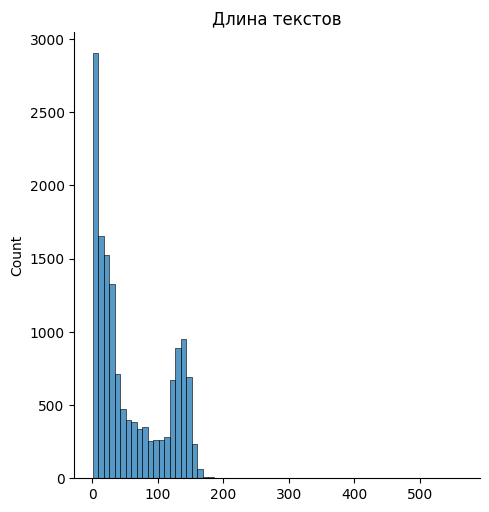

In [37]:
lengths = np.array([len(tokens) for (tokens,label) in train_tokens])
sns.displot(lengths)
plt.title('Длина текстов')
plt.show();

In [96]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

BATCH_SIZE = 64
def generate_batch(data_batch):
      labels = []
      tokens_batch = []
      for (tokens,label) in data_batch:
        tokens_batch.append(tokens)
        labels.append(label)
      return pad_sequence(tokens_batch, padding_value=vocab['<pad>'],batch_first = True), torch.tensor(labels).float()

train_iter = DataLoader(train_tokens, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_tokens, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)
test_iter = DataLoader(test_tokens, batch_size=BATCH_SIZE,
                        shuffle=False, collate_fn=generate_batch)

In [47]:
import random
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False

In [58]:
from torch import nn,Tensor,optim

class LSTMClassifier(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int,
                 hid_dim: int,
                 out_dim: int,
                 n_layers : int,
                 dropout: float):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim)

        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers = n_layers,  bidirectional = True, batch_first = True, dropout = dropout)

        self.fc = nn.Linear(hid_dim * 2, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self,texts):

        embedded = self.dropout(self.embedding(texts))

        outputs, (hidden, _) = self.lstm(embedded)

        hidden = self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return hidden

In [46]:
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score

def plot_losses(train_losses, test_losses, train_auc, test_auc):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_auc) + 1), train_auc, label='train')
    axs[1].plot(range(1, len(test_auc) + 1), test_auc, label='test')
    axs[1].set_ylabel('auc')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [79]:
import torch
from tqdm.notebook import tqdm

def train_epoch(model: nn.Module,
          iterator: torch.utils.data.DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss,epoch_auc = 0,0

    for tokens_batch,labels in tqdm(iterator):
        tokens_batch = tokens_batch.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(tokens_batch)

        output = torch.sigmoid(logits.squeeze(1))
        
        loss = criterion(output, labels)

        loss.backward()

        roc_auc = roc_auc_score(labels.cpu(),output.cpu().detach())

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        epoch_auc += roc_auc


    return epoch_loss / len(iterator), epoch_auc / len(iterator)


def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module):

    model.eval()

    epoch_loss,epoch_auc = 0,0

    with torch.no_grad():
        for (tokens_batch,labels) in tqdm(iterator):
            tokens_batch = tokens_batch.to(device)
            labels = labels.to(device)

            logits = model(tokens_batch)

            output = torch.sigmoid(logits.squeeze(1))

            loss = criterion(output, labels)

            epoch_loss += loss.item()

            roc_auc = roc_auc_score(labels.cpu(),output.cpu().detach())

            epoch_loss += loss.item()
            epoch_auc += roc_auc

    return epoch_loss / len(iterator), epoch_auc / len(iterator)

def predict(model,iterator):
    model.eval()
    outputs = []
    with torch.no_grad():
        for (tokens_batch,labels) in tqdm(iterator):
            tokens_batch = tokens_batch.to(device)
            logits = model(tokens_batch)
            output = torch.sigmoid(logits.squeeze(1))
            outputs.append(output)
    result = torch.cat(outputs,dim = 0)
    return result.cpu().detach()

In [49]:
def train(model,optimizer,criterion,clip,n_epochs,scheduler = None):
    train_losses,valid_losses,valid_auc_list,train_auc_list = [],[],[],[]

    for epoch in range(n_epochs):

        train_loss,train_auc = train_epoch(model, train_iter, optimizer, criterion, clip)
        valid_loss, valid_auc = evaluate(model, valid_iter, criterion)

        train_losses += [train_loss]
        train_auc_list += [train_auc]
        valid_losses += [valid_loss]
        valid_auc_list += [valid_auc]

        plot_losses(train_losses,valid_losses, train_auc_list ,valid_auc_list)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train AUC: {train_auc:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.3f}')
        
        if scheduler is not None:
            scheduler.step()

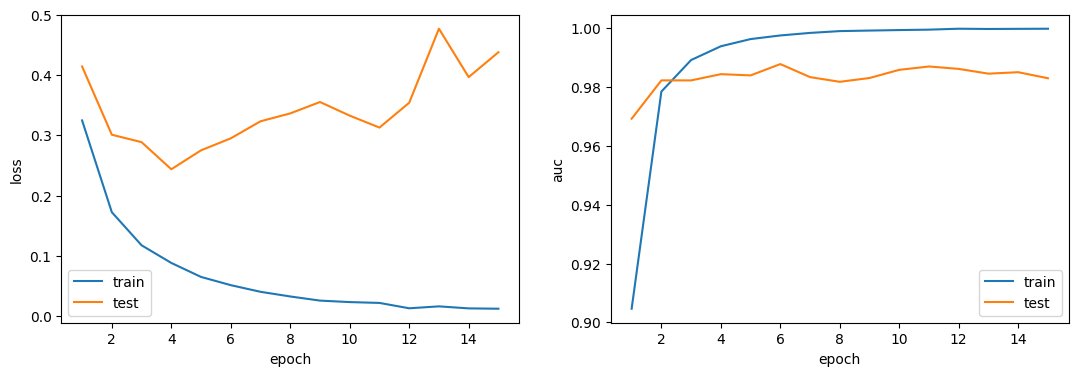

Epoch: 15
	Train Loss: 0.012 | Train AUC: 1.000
	 Val. Loss: 0.438 |  Val. AUC: 0.983


In [53]:
VOCAB_SIZE = len(vocab)
EMB_DIM = 64
HID_DIM = 128
OUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.2
N_EPOCHS = 15
CLIP = 1

fix_seed(122333)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(vocab_size = VOCAB_SIZE,
                 emb_dim = EMB_DIM,
                 hid_dim = HID_DIM,
                 out_dim = OUT_DIM,
                 n_layers = N_LAYERS,
                 dropout = DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

train(model,optimizer,criterion,CLIP,N_EPOCHS)

Видно что у нас модель немного переобучилась поэтому попробуем уменьшить learning rate и увеличить количество эпох

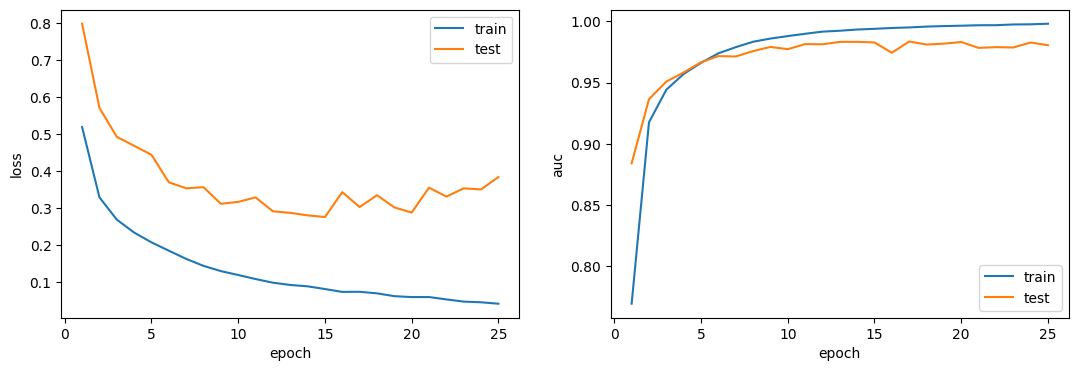

Epoch: 25
	Train Loss: 0.042 | Train AUC: 0.998
	 Val. Loss: 0.384 |  Val. AUC: 0.980


In [54]:
VOCAB_SIZE = len(vocab)
EMB_DIM = 64
HID_DIM = 128
OUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.2
N_EPOCHS = 25
CLIP = 1

fix_seed(122333)

model = LSTMClassifier(vocab_size = VOCAB_SIZE,
                 emb_dim = EMB_DIM,
                 hid_dim = HID_DIM,
                 out_dim = OUT_DIM,
                 n_layers = N_LAYERS,
                 dropout = DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

fix_seed(122333)
train(model,optimizer,criterion,CLIP,N_EPOCHS)

Обучение стало более стабильным, но добавим еще шедулер чтобы уменьшать learning rate в процессе обучения

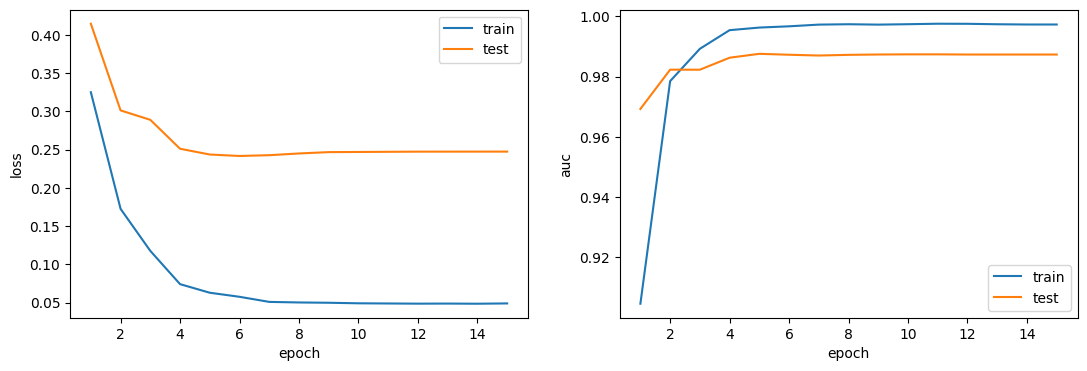

Epoch: 15
	Train Loss: 0.049 | Train AUC: 0.997
	 Val. Loss: 0.247 |  Val. AUC: 0.987


In [55]:
VOCAB_SIZE = len(vocab)
EMB_DIM = 64
HID_DIM = 128
OUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.2
N_EPOCHS = 15
CLIP = 1

fix_seed(122333)

model = LSTMClassifier(vocab_size = VOCAB_SIZE,
                 emb_dim = EMB_DIM,
                 hid_dim = HID_DIM,
                 out_dim = OUT_DIM,
                 n_layers = N_LAYERS,
                 dropout = DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
criterion = nn.BCELoss()

train(model,optimizer,criterion,CLIP,N_EPOCHS,scheduler)

В конце у нас модель почти не учится скорее всего потому что lr затухает очень быстро, попробуем другой шедулер

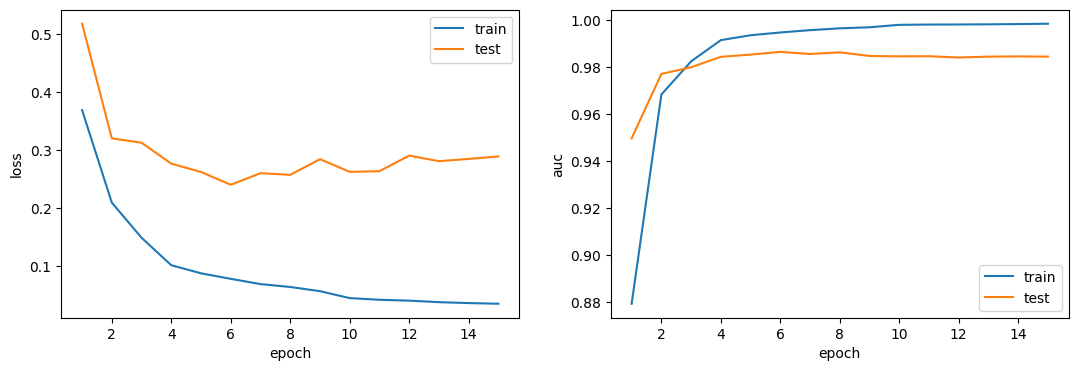

Epoch: 15
	Train Loss: 0.035 | Train AUC: 0.998
	 Val. Loss: 0.289 |  Val. AUC: 0.984


In [56]:
VOCAB_SIZE = len(vocab)
EMB_DIM = 64
HID_DIM = 128
OUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.2
N_EPOCHS = 15
CLIP = 1

fix_seed(122333)

model = LSTMClassifier(vocab_size = VOCAB_SIZE,
                 emb_dim = EMB_DIM,
                 hid_dim = HID_DIM,
                 out_dim = OUT_DIM,
                 n_layers = N_LAYERS,
                 dropout = DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,9], gamma=0.3)
criterion = nn.BCELoss()

train(model,optimizer,criterion,CLIP,N_EPOCHS,scheduler)

Попробуем добавить еще один дропаут в эмбеддинги

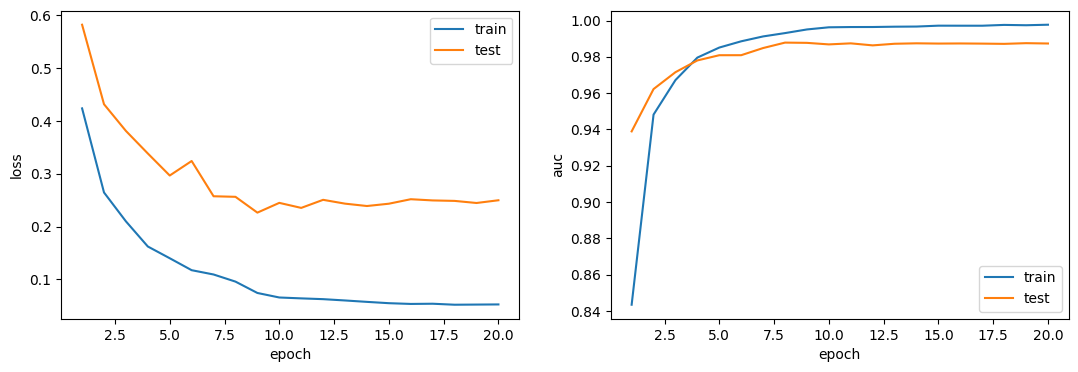

Epoch: 20
	Train Loss: 0.053 | Train AUC: 0.998
	 Val. Loss: 0.250 |  Val. AUC: 0.987


In [61]:
VOCAB_SIZE = len(vocab)
EMB_DIM = 64
HID_DIM = 128
OUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.15
N_EPOCHS = 20
CLIP = 1

fix_seed(122333)

model = LSTMClassifier(vocab_size = VOCAB_SIZE,
                 emb_dim = EMB_DIM,
                 hid_dim = HID_DIM,
                 out_dim = OUT_DIM,
                 n_layers = N_LAYERS,
                 dropout = DROPOUT).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8,13], gamma=0.2)
criterion = nn.BCELoss()

train(model,optimizer,criterion,CLIP,N_EPOCHS,scheduler = scheduler)

Попробуем другой оптимизатор - SGD with momentum

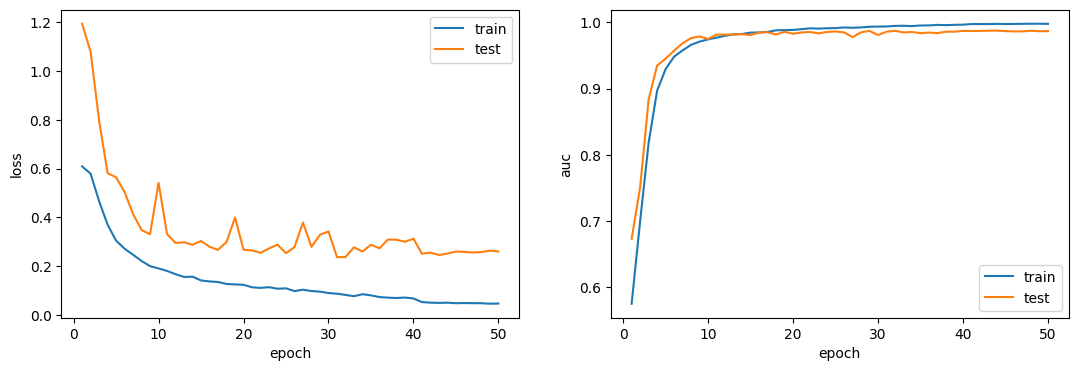

Epoch: 50
	Train Loss: 0.047 | Train AUC: 0.998
	 Val. Loss: 0.261 |  Val. AUC: 0.987


In [72]:
VOCAB_SIZE = len(vocab)
EMB_DIM = 64
HID_DIM = 64
OUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.15
N_EPOCHS = 50
CLIP = 1

fix_seed(122333)

model = LSTMClassifier(vocab_size = VOCAB_SIZE,
                 emb_dim = EMB_DIM,
                 hid_dim = HID_DIM,
                 out_dim = OUT_DIM,
                 n_layers = N_LAYERS,
                 dropout = DROPOUT).to(device)
optimizer = torch.optim.SGD(model.parameters(),momentum = 0.9,lr = 1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=0.1)
criterion = nn.BCELoss()

train(model,optimizer,criterion,CLIP,N_EPOCHS,scheduler = scheduler)

Проскорим лучшей моделью тестовую выборку

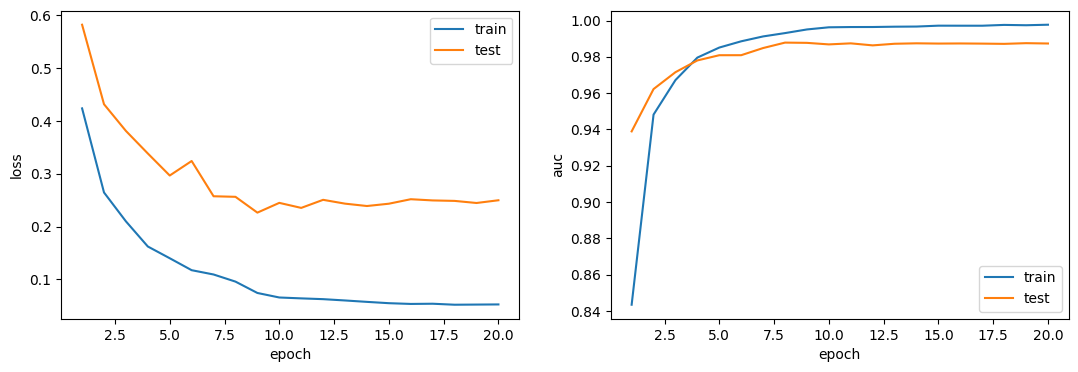

Epoch: 20
	Train Loss: 0.053 | Train AUC: 0.998
	 Val. Loss: 0.250 |  Val. AUC: 0.987


In [73]:
VOCAB_SIZE = len(vocab)
EMB_DIM = 64
HID_DIM = 128
OUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.15
N_EPOCHS = 20
CLIP = 1

fix_seed(122333)

best_model = LSTMClassifier(vocab_size = VOCAB_SIZE,
                 emb_dim = EMB_DIM,
                 hid_dim = HID_DIM,
                 out_dim = OUT_DIM,
                 n_layers = N_LAYERS,
                 dropout = DROPOUT).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8,13], gamma=0.2)
criterion = nn.BCELoss()

train(best_model,optimizer,criterion,CLIP,N_EPOCHS,scheduler = scheduler)

In [97]:
output = predict(best_model,valid_iter)

  0%|          | 0/26 [00:00<?, ?it/s]

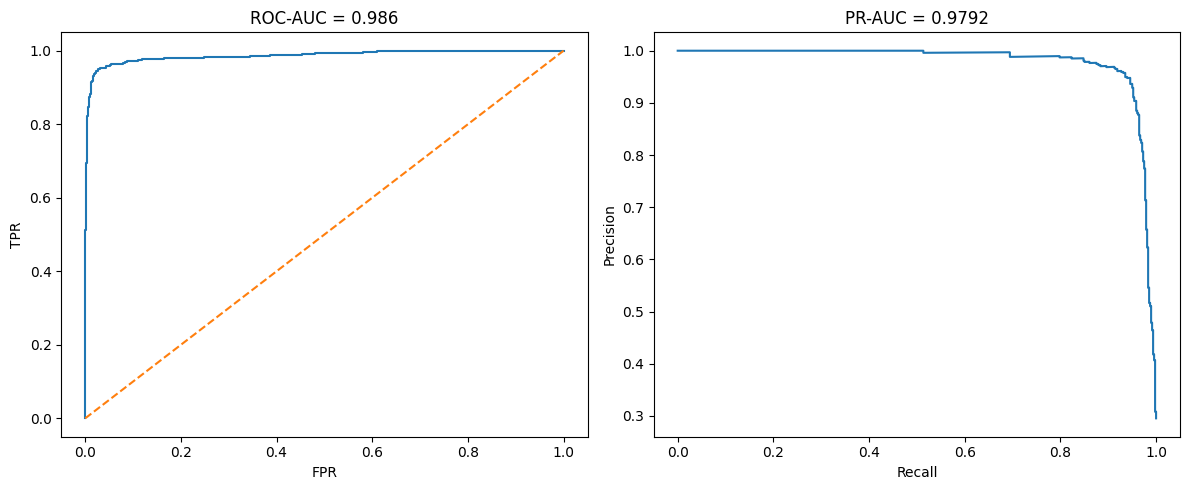

(0.986, 0.9792)

In [98]:
evaluate_metrics(y_valid,output,draw = True)

In [99]:
test_output = predict(best_model,test_iter)

  0%|          | 0/64 [00:00<?, ?it/s]

In [103]:
test['score'] = test_output

In [106]:
test[['score','text']].to_csv('spam_detection.csv')